In [1]:
import numpy as np
import pandas as pd
import datetime
import csv
import re
import string
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
import spacy

import pattern
from pattern.en import lemma, lexeme

from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, log_loss

In [2]:
with open('echo_plus.pkl','rb') as read_file:
    plus_df = pickle.load(read_file)

In [3]:
plus_df.head()

,rating,date,variation,verified_reviews,feedback,length,reviews
1750,4,31-Jul-18,Echo Plus,We use Alexa primarily for listening to music ...,1,205,use alexa primarily listen music check weather...
1751,5,31-Jul-18,Echo Plus,Plug n Play set up is simple. Added battery ba...,1,103,plug n play set simple add battery base make p...
1752,5,30-Jul-18,Echo Plus,Great speaker i n this! I love this so much mo...,1,126,great speaker n love much alexa tap -PRON- ’s ...
1753,4,30-Jul-18,Echo Plus,She's [Alexa] a bit dense and still learning t...,1,99,alexa bit dense still learn way phrase thing n...
1754,5,30-Jul-18,Echo Plus,Great sound and easy to set up. Purchased the ...,1,155,great sound easy set purchase echo plus build ...


In [4]:
plus_df['reviews'].replace('-PRON-', '', inplace=True)

In [5]:
#create dictionary to do a count
count_dict_plus = {}

for doc in plus_df['reviews']:
    for word in doc.split():
        if word in count_dict_plus.keys():
            count_dict_plus[word] +=1
        else:
            count_dict_plus[word] = 1
            
for key, value in sorted(count_dict_plus.items(), key=lambda item: item[1]):
    print("%s: %s" % (key, value))

primarily: 1
tap: 1
prettier: 1
dense: 1
phrase: 1
ny: 1
nj: 1
regional: 1
omg: 1
positive: 1
surround: 1
none: 1
novelty: 1
e: 1
spur: 1
wikipedia: 1
dictionary: 1
reduce: 1
auto: 1
connectivity: 1
imrprove: 1
edit: 1
string: 1
r: 1
explicit: 1
electeonically: 1
feee: 1
lifht: 1
content: 1
variety: 1
bing: 1
engine: 1
pleasantly: 1
accuracy: 1
fidelity: 1
silver: 1
fabric: 1
unimportant: 1
intention: 1
mini: 1
scottish: 1
navigate: 1
intend: 1
hmm: 1
spec: 1
intuitive: 1
perfectly: 1
stubborn: 1
sell: 1
patio: 1
gathering: 1
extend: 1
yard: 1
currently: 1
impair: 1
fairly: 1
loaded: 1
email: 1
common: 1
social: 1
medium: 1
facebook: 1
twitt: 1
other: 1
isolate: 1
who: 1
guy: 1
wanted: 1
desk: 1
dog: 1
distract: 1
noise: 1
itune: 1
countless: 1
dunce: 1
sigh: 1
exasperation: 1
workaround: 1
mediocre: 1
scour: 1
section: 1
address: 1
advanced: 1
accept: 1
karen: 1
versatility: 1
intercom: 1
controllable: 1
cup: 1
briefing: 1
secretary: 1
slight: 1
own: 1
controller: 1
sounding: 1
fire: 

In [6]:
low_value = 20
bad_words = [key for key in count_dict_plus.keys() if count_dict_plus[key] < low_value]

corpus = [doc.split() for doc in plus_df['reviews']]
#a list of lists where each document is a string broken into a list of words
clean_corpus = []
for document in corpus:
    clean_corpus.append([word for word in document if word not in bad_words])

In [7]:
corpus_cloud = ' '.join(plus_df['reviews'])

In [8]:
STOPWORDS.update(['PRON','would','also','’s'])

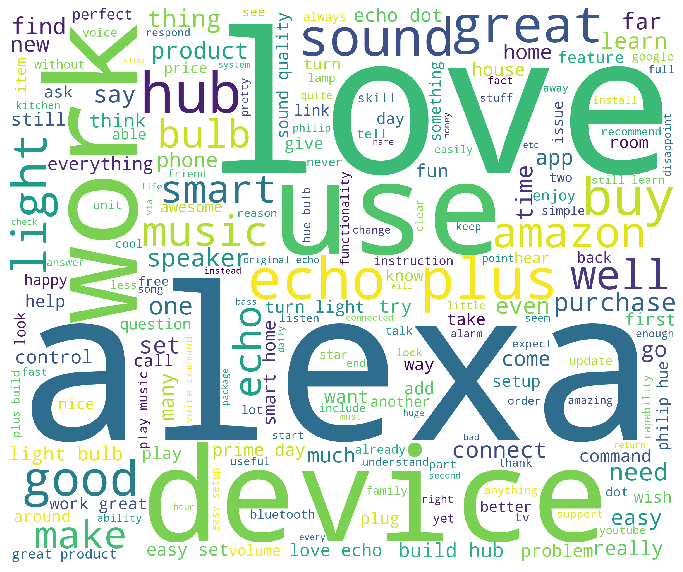

In [9]:
wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white',width=2400,height=2000).generate(corpus_cloud)
plt.figure(figsize=(12,15))
plt.imshow(wordcloud)
plt.axis('off')

# https://mubaris.com/posts/dataviz-wordcloud/
#plt.savefig("wordcloud.jpg")
plt.show()

### LDA

In [10]:
import gensim
from gensim import corpora
from gensim.models import LdaModel, LdaMulticore
import gensim.downloader as api
from gensim.utils import simple_preprocess, lemmatize
from nltk.corpus import stopwords

In [11]:
clean_corpus[0][:5]

['use', 'alexa', 'music', 'still', 'learn']

In [12]:
# Create the Inputs of LDA model: Dictionary and Corpus
dct = corpora.Dictionary(clean_corpus)
corpus = [dct.doc2bow(line) for line in clean_corpus]

In [13]:
# Train the LDA model
lda_model = LdaModel(corpus=corpus,
                         id2word=dct,
                         random_state=100,
                         num_topics=3,
                         passes=5,
                         per_word_topics=True)

# save the model
# lda_model.save('lda_model.model')

# See the topics
lda_model.print_topics(-1)

[(0,
  '0.103*"great" + 0.095*"sound" + 0.058*"easy" + 0.054*"work" + 0.052*"set" + 0.050*"use" + 0.049*"like" + 0.048*"device" + 0.033*"home" + 0.031*"echo"'),
 (1,
  '0.077*"echo" + 0.053*"hub" + 0.052*"alexa" + 0.047*"bulb" + 0.045*"light" + 0.040*"plus" + 0.038*"device" + 0.034*"use" + 0.027*"work" + 0.023*"buy"'),
 (2,
  '0.097*"love" + 0.043*"echo" + 0.038*"product" + 0.037*"alexa" + 0.036*"not" + 0.034*"smart" + 0.034*"good" + 0.028*"buy" + 0.028*"music" + 0.027*"work"')]

### Word2Vec

In [14]:
from gensim.models.word2vec import Word2Vec
from multiprocessing import cpu_count
import gensim.downloader as api

In [15]:
# Train Word2Vec model. Defaults result vector size = 100
model = Word2Vec(clean_corpus, min_count = 0, workers=cpu_count())

# Get the word vector for given word
model['sound']

model.most_similar('sound')

/Users/kelseyheng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
/Users/kelseyheng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  import sys


[('bulb', 0.9262158274650574),
 ('alexa', 0.9198694229125977),
 ('hub', 0.9198002815246582),
 ('echo', 0.9183480739593506),
 ('one', 0.9125509858131409),
 ('light', 0.9044260382652283),
 ('hue', 0.9008668661117554),
 ('device', 0.9007163047790527),
 ('amazon', 0.891891360282898),
 ('plus', 0.8915492296218872)]

### Bigram

In [16]:
dct = corpora.Dictionary(clean_corpus)
corpus = [dct.doc2bow(line) for line in clean_corpus]

# Build the bigram models
bigram = gensim.models.phrases.Phrases(clean_corpus, min_count=3, threshold=10)

# Construct bigram
print(bigram[clean_corpus[1]])


['play', 'set', 'make', 'use', 'hub']


/Users/kelseyheng/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


### Vader

In [17]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [18]:
analyser = SentimentIntensityAnalyzer()

In [19]:
def sentimentScore(sentences):
    analyzer = SentimentIntensityAnalyzer()
    results = []
    for sentence in sentences:
        vs = analyzer.polarity_scores(sentence)
        print(str(vs))
        results.append(vs) 
    return results

In [20]:
sentiment = sentimentScore(plus_df['reviews'])

{'neg': 0.0, 'neu': 0.55, 'pos': 0.45, 'compound': 0.9201}
{'neg': 0.0, 'neu': 0.833, 'pos': 0.167, 'compound': 0.34}
{'neg': 0.0, 'neu': 0.39, 'pos': 0.61, 'compound': 0.9337}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.548, 'pos': 0.452, 'compound': 0.872}
{'neg': 0.0, 'neu': 0.429, 'pos': 0.571, 'compound': 0.8519}
{'neg': 0.0, 'neu': 0.3, 'pos': 0.7, 'compound': 0.7906}
{'neg': 0.0, 'neu': 0.417, 'pos': 0.583, 'compound': 0.6369}
{'neg': 0.0, 'neu': 0.192, 'pos': 0.808, 'compound': 0.6369}
{'neg': 0.11, 'neu': 0.638, 'pos': 0.252, 'compound': 0.6124}
{'neg': 0.0, 'neu': 0.625, 'pos': 0.375, 'compound': 0.5574}
{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.037, 'neu': 0.667, 'pos': 0.296, 'compound': 0.8511}
{'neg': 0.0, 'neu': 0.378, 'pos': 0.622, 'compound': 0.8714}
{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.588, 'pos': 0.412, 'compound': 0.7906}
{'neg': 0.0, 'neu': 0.408, 'pos': 0.592, 'compound': 

{'neg': 0.0, 'neu': 0.743, 'pos': 0.257, 'compound': 0.5859}
{'neg': 0.17, 'neu': 0.758, 'pos': 0.072, 'compound': -0.4019}
{'neg': 0.0, 'neu': 0.472, 'pos': 0.528, 'compound': 0.9081}
{'neg': 0.0, 'neu': 0.643, 'pos': 0.357, 'compound': 0.6124}
{'neg': 0.639, 'neu': 0.361, 'pos': 0.0, 'compound': -0.6486}
{'neg': 0.0, 'neu': 0.769, 'pos': 0.231, 'compound': 0.2732}
{'neg': 0.0, 'neu': 0.417, 'pos': 0.583, 'compound': 0.4215}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.133, 'pos': 0.867, 'compound': 0.7579}
{'neg': 0.0, 'neu': 0.196, 'pos': 0.804, 'compound': 0.6249}
{'neg': 0.0, 'neu': 0.815, 'pos': 0.185, 'compound': 0.3612}
{'neg': 0.062, 'neu': 0.763, 'pos': 0.174, 'compound': 0.7783}
{'neg': 0.0, 'neu': 0.754, 'pos': 0.246, 'compound': 0.7579}
{'neg': 0.0, 'neu': 0.541, 'pos': 0.459, 'compound': 0.9371}
{'neg': 0.304, 'neu': 0.361, 'pos': 0.334, 'compound': 0.0854}
{'neg': 0.0, 'neu': 0.83, 'pos': 0.17, 'compound': 0.6249}
{'neg': 0.141, 'neu': 0.56

In [21]:
sentiment_df = pd.DataFrame(sentiment)
sentiment_df.head()

,compound,neg,neu,pos
0,0.9201,0.0,0.550,0.450
1,0.3400,0.0,0.833,0.167
2,0.9337,0.0,0.390,0.610
3,0.0000,0.0,1.000,0.000
4,0.8720,0.0,0.548,0.452


In [22]:
# align index to copy rating column for joining
plus_df.index = sentiment_df.index
sentiment_df['rating'] = plus_df['rating']
plus_vader = pd.concat([plus_df, sentiment_df], axis=1)
plus_vader.head()

,rating,date,variation,verified_reviews,feedback,length,reviews,compound,neg,neu,pos,rating
0,4,31-Jul-18,Echo Plus,We use Alexa primarily for listening to music ...,1,205,use alexa primarily listen music check weather...,0.9201,0.0,0.550,0.450,4
1,5,31-Jul-18,Echo Plus,Plug n Play set up is simple. Added battery ba...,1,103,plug n play set simple add battery base make p...,0.3400,0.0,0.833,0.167,5
2,5,30-Jul-18,Echo Plus,Great speaker i n this! I love this so much mo...,1,126,great speaker n love much alexa tap -PRON- ’s ...,0.9337,0.0,0.390,0.610,5
3,4,30-Jul-18,Echo Plus,She's [Alexa] a bit dense and still learning t...,1,99,alexa bit dense still learn way phrase thing n...,0.0000,0.0,1.000,0.000,4
4,5,30-Jul-18,Echo Plus,Great sound and easy to set up. Purchased the ...,1,155,great sound easy set purchase echo plus build ...,0.8720,0.0,0.548,0.452,5


In [23]:
# find % of good rating vs compound

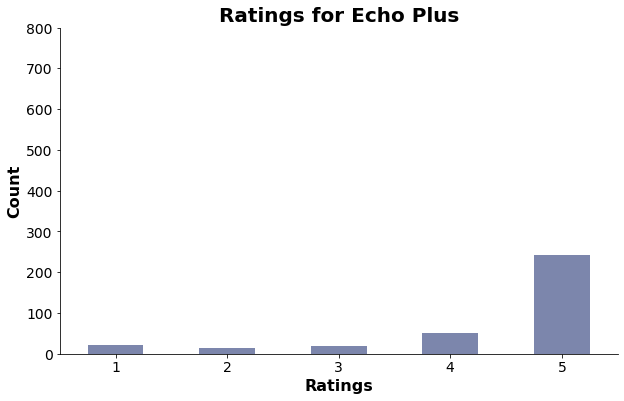

In [24]:
group = plus_df.groupby('rating').count()
group['date']

color = plt.cm.bone(np.linspace(0, 1, 6))
ax = group['date'].plot.bar(color='#7c86ac', figsize = (10, 6))

plt.title('Ratings for Echo Plus', fontsize = 20, weight='bold')
plt.xlabel('Ratings', fontsize = 16, weight='bold')
plt.ylabel('Count', fontsize=16, weight='bold')
ax.set_ylim([0,800])

plt.xticks(rotation='0', fontsize=14)
plt.yticks(fontsize=14)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.show()

#change colour

### Sentiment features

In [25]:
# seperate ratings below 2 vs above 2
neg_plus = plus_df[plus_df['rating']<3]
pos_plus = plus_df[plus_df['rating']>3]

### negative

In [26]:
from sklearn.feature_selection import chi2

tfidf_n = TfidfVectorizer(ngram_range=(2, 2))
X_tfidf_n = tfidf_n.fit_transform(neg_plus['reviews'])
y_n = neg_plus['rating']
chi2score_n = chi2(X_tfidf_n, y_n)[0]

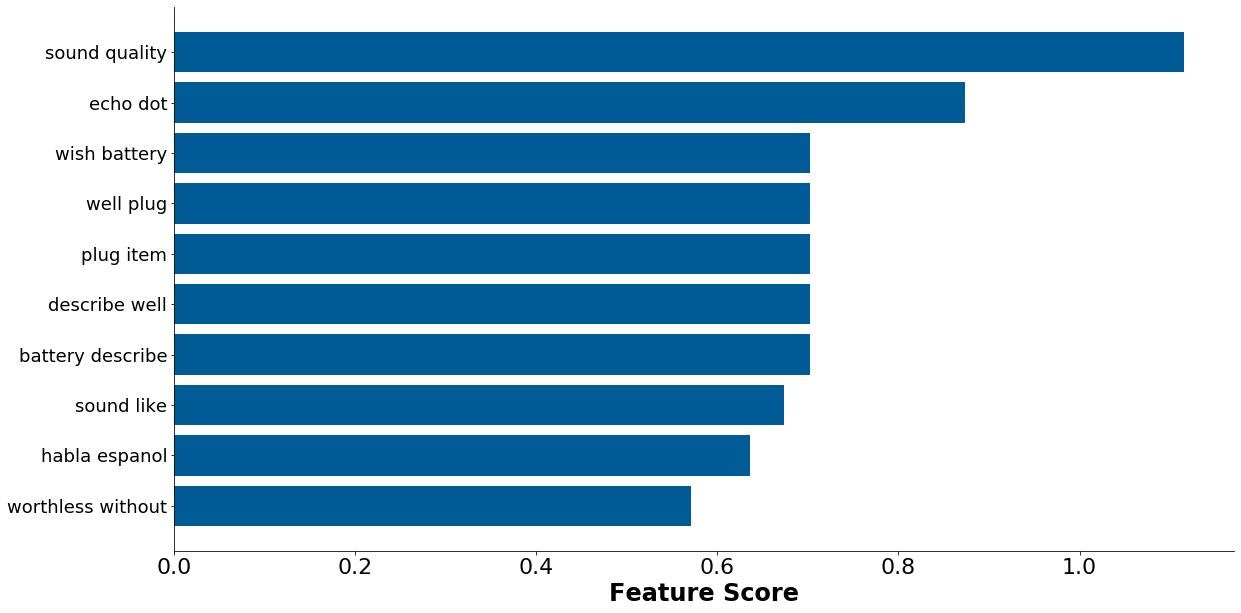

''

<Figure size 432x288 with 0 Axes>

In [27]:
# color = ['#63ace5','#adcbe3','#005b96']

scores = list(zip(tfidf_n.get_feature_names(), chi2score_n))
chi2_n = sorted(scores, key=lambda x:x[1])
topchi2_n = list(zip(*chi2_n[-10:]))
x_n=range(len(topchi2_n[1]))

fig, ax = plt.subplots(figsize=(19,10))
ax.barh(x_n, topchi2_n[1], align='center', alpha=1, color='#005b96')

# plt.title('Echo Dot Postive Feedback', fontsize=20, weight='bold')

# x-axis
plt.xlabel("Feature Score", fontsize=24, weight='bold')
plt.xticks(fontsize=22)

#y-axis
labels = topchi2_n[0]
plt.yticks(x_n, labels, fontsize=18)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

fig = plt.gcf()
plt.show()
plt.draw()

fig.savefig('plus_neg.jpg')
;

### positive

In [28]:
tfidf = TfidfVectorizer(ngram_range=(2, 2))
X_tfidf = tfidf.fit_transform(pos_plus['reviews'])
y = pos_plus['rating']
chi2score = chi2(X_tfidf, y)[0]

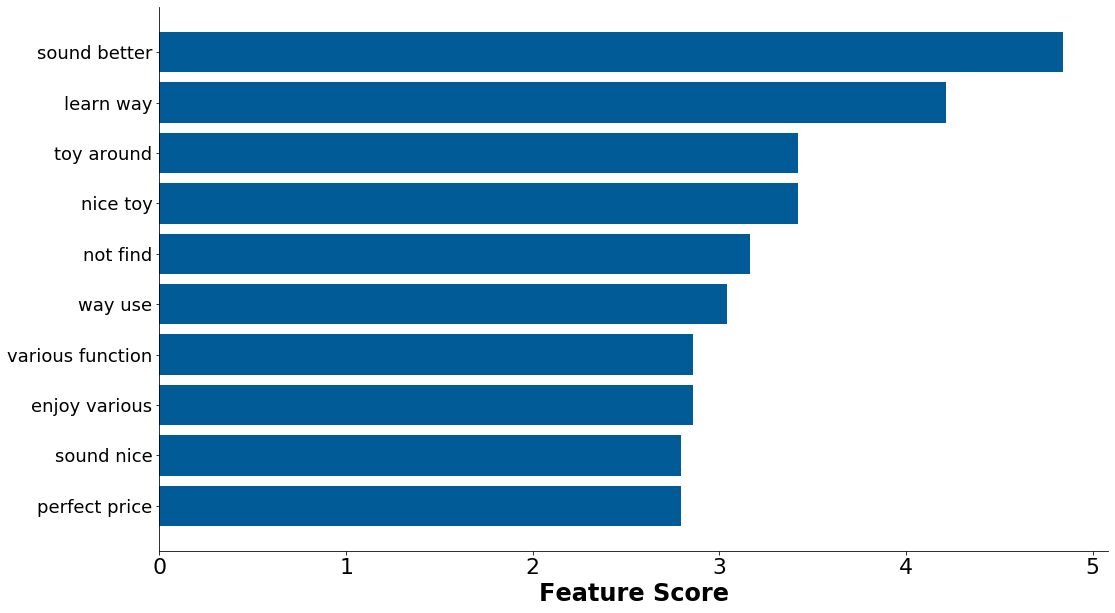

''

<Figure size 432x288 with 0 Axes>

In [29]:
scores = list(zip(tfidf.get_feature_names(), chi2score))
chi2 = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*chi2[-10:]))
x=range(len(topchi2[1]))

fig, ax = plt.subplots(figsize=(17,10))
ax.barh(x,topchi2[1], align='center', alpha=1, color='#005b96')

# plt.title('Echo Dot Postive Feedback', fontsize=20, weight='bold')

# x-axis
plt.xlabel("Feature Score", fontsize=24, weight='bold')
plt.xticks(fontsize=22)

#y-axis
labels = topchi2[0]
plt.yticks(x, labels, fontsize=18)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

fig = plt.gcf()
plt.show()
plt.draw()

fig.savefig('plus_positive.jpg')
;